In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empyrical import max_drawdown
from calendar import monthrange
import warnings


warnings.filterwarnings("ignore")
#Annual rebalancing
def yearly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025): 
        start_date = f"{year-1}-12-31"
        end_date = f"{year}-12-31"
        start_price = df['Adj Close'].loc[:start_date].iloc[-1]
        end_price = df['Adj Close'].loc[:end_date].iloc[-1]
        yearly_return = (end_price - start_price) / start_price
        returns[year] = yearly_return
    return pd.Series(returns)

tickers = ['SID', 'GGB', 'SBS', 'SUZ', 'VALE', 'PBR', 'ITUB', 'BAK', 'BBD']

data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}

yearly_returns_dict = {key: yearly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(yearly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_annual_w = []
cash_annual_m = []
cash_annual_l = []

for year in range(2014, 2024):
    sorted_returns = final_df.loc[year].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_year = year + 1
    if next_year in final_df.index:
        returns_next_year_w = final_df.loc[next_year][last_three.index]
        total_return_w = ((cash_w / 3) * (1 + returns_next_year_w)).sum()
        cash_w = total_return_w
        cash_annual_w.append((year + 1, cash_w))
        returns_next_year_m = final_df.loc[next_year][middle_three.index]
        total_return_m = ((cash_m / 3) * (1 + returns_next_year_m)).sum()
        cash_m = total_return_m
        cash_annual_m.append((year + 1, cash_m))
        returns_next_year_l = final_df.loc[next_year][first_three.index]
        total_return_l = ((cash_l / 3) * (1 + returns_next_year_l)).sum()
        cash_l = total_return_l
        cash_annual_l.append((year + 1, cash_l))

years_w, cash_values_w = zip(*cash_annual_w)
years_m, cash_values_m = zip(*cash_annual_m)
years_l, cash_values_l = zip(*cash_annual_l)

years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w})
df1["Median"]=cash_values_m
df1["Losers"]=cash_values_l

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in range(2014, 2025):
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for year in range(2014, 2025):
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[year].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_year = selected_returns[selected_returns.index.year == year+1]
        avg_daily_returns = selected_returns_year.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_a = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_a_maxdd=max_drawdowns_values_a["top"]
m_a_maxdd=max_drawdowns_values_a["middle"]
l_a_maxdd=max_drawdowns_values_a["bottom"]

df2=pd.DataFrame()
df2=df1
df2.head(10)
#df1.to_csv("annual.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2015,71.730792,75.687146,48.152123,-28.269208,-24.312854,-51.847877,31.553550,44.009466,57.672008,-0.895912,-0.552446,-0.899013,-39.205379,-39.457041,-63.088658
2016,109.274242,188.969377,113.210745,52.339376,149.671692,135.110602,31.228605,63.316929,60.878696,1.676007,2.363850,2.219341,-14.201723,-33.310362,-27.816144
2017,108.052920,269.037727,150.424717,-1.117666,42.371071,32.871412,42.628474,30.143031,24.936112,-0.026219,1.405667,1.318225,-42.261988,-21.483017,-14.601500
2018,135.899739,259.592912,160.795641,25.771463,-3.510591,6.894428,31.873226,32.361349,44.304099,0.808561,-0.108481,0.155616,-16.417335,-36.591091,-35.087581
2019,150.623440,303.625454,226.180155,10.834238,16.962151,40.663114,27.011783,30.318552,33.348976,0.401093,0.559464,1.219321,-29.484898,-27.285684,-27.666710
2020,164.858700,203.453679,231.384259,9.450893,-32.991890,2.300867,72.192956,69.087214,61.794418,0.130912,-0.477540,0.037234,-66.366900,-63.924368,-61.296017
2021,149.996001,214.541151,324.961112,-9.015417,5.449629,40.442186,37.362476,37.742030,36.176466,-0.241296,0.144392,1.117914,-46.299172,-25.761555,-26.967713
2022,164.630142,262.411253,311.287547,9.756354,22.312783,-4.207754,41.503457,35.184324,42.510811,0.235073,0.634168,-0.098981,-31.803408,-32.927395,-41.503903
2023,269.288089,284.690009,415.556264,63.571559,8.490015,33.495949,28.100049,26.236074,36.826911,2.262329,0.323601,0.909551,-15.964537,-22.437612,-29.988911


In [2]:
#Semi-Annual Rebalancing
import pandas as pd
import matplotlib.pyplot as plt

#returns calculation
def semi_annual_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025):
        start_date_1 = f"{year-1}-12-31"
        end_date_1 = f"{year}-06-30"
        start_price_1 = df['Adj Close'].loc[:start_date_1].iloc[-1]
        end_price_1 = df['Adj Close'].loc[:end_date_1].iloc[-1]
        half_year_return_1 = (end_price_1 - start_price_1) / start_price_1
        returns[f"{year}-01"] = half_year_return_1
        
        start_date_2 = f"{year}-06-30"
        end_date_2 = f"{year}-12-31"
        start_price_2 = df['Adj Close'].loc[:start_date_2].iloc[-1]
        end_price_2 = df['Adj Close'].loc[:end_date_2].iloc[-1]
        half_year_return_2 = (end_price_2 - start_price_2) / start_price_2
        returns[f"{year}-02"] = half_year_return_2
    
    return pd.Series(returns)

tickers = ['SID', 'GGB', 'SBS', 'SUZ', 'VALE', 'PBR', 'ITUB', 'BAK', 'BBD']
data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}

semi_annual_returns_dict = {key: semi_annual_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(semi_annual_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_semi_annual_w = []
cash_semi_annual_m = []
cash_semi_annual_l = []

#cash calculation
for period in final_df.index[1:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_semi_annual_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_semi_annual_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_semi_annual_l.append((next_period, cash_l))

periods_w, cash_values_w = zip(*cash_semi_annual_w)
periods_m, cash_values_m = zip(*cash_semi_annual_m)
periods_l, cash_values_l = zip(*cash_semi_annual_l)
cash_values_w=cash_values_w[1::2]
cash_values_m=cash_values_m[1::2]
cash_values_l=cash_values_l[1::2]
years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w})
df1["Median"]=cash_values_m
df1["Losers"]=cash_values_l

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100
# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[1:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])


# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[1:]:
    year, half = int(date[:4]), int(date[-1])
    
    if half == 1:
        current_date = pd.Timestamp(year=year, month=1, day=1)
        next_half_start = pd.Timestamp(year=year, month=7, day=1)
        next_half_end = pd.Timestamp(year=year, month=12, day=31)
    else:
        current_date = pd.Timestamp(year=year, month=7, day=1)
        next_half_start = pd.Timestamp(year=year+1, month=1, day=1)
        next_half_end = pd.Timestamp(year=year+1, month=6, day=30)
    
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        
        # Ensure that the end date does not exceed the dataset's available date range
        next_half_end = min(next_half_end, daily_returns_df.index[-1])
        
        # Select returns for the calculated period
        selected_returns_period = selected_returns.loc[next_half_start:next_half_end]
        avg_daily_returns = selected_returns_period.mean(axis=1)
        
        # average daily returns concatenation
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_sa = {group: round(float(value), 2) if isinstance(value, (float, np.float64)) else round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_sa_maxdd = max_drawdowns_values_sa["top"]
m_sa_maxdd = max_drawdowns_values_sa["middle"]
l_sa_maxdd = max_drawdowns_values_sa["bottom"]

df3=pd.DataFrame()
df3=df1
df3.head(10)
#df1.to_csv("semiannual.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2015,62.447706,51.907695,86.015998,-37.552294,-48.092305,-13.984002,35.137966,47.559811,50.005498,-1.068710,-1.011196,-0.279649,-43.928700,-54.418220,-47.728700
2016,87.091115,148.746195,207.099704,39.462474,186.559045,140.768820,37.614034,65.506919,55.706474,1.049142,2.847929,2.526974,-19.940333,-34.799255,-26.871040
2017,112.431245,166.988671,270.049426,29.096114,12.264163,30.395853,32.038295,36.434472,30.932088,0.908167,0.336609,0.982664,-27.536439,-36.709002,-21.995722
2018,143.358804,180.675187,264.658468,27.507975,8.196075,-1.996286,31.704663,38.946779,39.436327,0.867632,0.210443,-0.050620,-17.569225,-37.165112,-42.843636
2019,188.100248,279.374489,232.228255,31.209415,54.628034,-12.253609,31.712885,32.395041,29.875789,0.984124,1.686309,-0.410152,-22.549731,-24.482237,-42.780016
2020,175.399963,322.512983,166.895426,-6.751870,15.441100,-28.133023,59.697837,65.468043,76.320990,-0.113101,0.235857,-0.368614,-59.059513,-60.317990,-70.267631
2021,173.199456,351.100794,205.781548,-1.254565,8.864080,23.299693,39.322846,36.213186,34.642042,-0.031904,0.244775,0.672584,-47.745223,-24.425378,-26.116000
2022,218.557342,358.558392,191.268502,26.188238,2.124062,-7.052647,38.945857,35.257437,46.898677,0.672427,0.060244,-0.150381,-24.708850,-34.779805,-47.051001
2023,313.653431,457.127404,261.877604,43.510819,27.490365,36.916220,28.045814,33.604515,29.515283,1.551419,0.818056,1.250749,-20.075520,-30.608035,-23.563087


In [3]:
# Quarterly Rebalancing

import pandas as pd
import matplotlib.pyplot as plt

#returns calculations
def quarterly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025):
        
        start_date_1 = f"{year-1}-12-31"
        end_date_1 = f"{year}-03-31"
        start_price_1 = df['Adj Close'].loc[:start_date_1].iloc[-1]
        end_price_1 = df['Adj Close'].loc[:end_date_1].iloc[-1]
        quarter_return_1 = (end_price_1 - start_price_1) / start_price_1
        returns[f"{year}-Q1"] = quarter_return_1
        
        start_date_2 = f"{year}-03-31"
        end_date_2 = f"{year}-06-30"
        start_price_2 = df['Adj Close'].loc[:start_date_2].iloc[-1]
        end_price_2 = df['Adj Close'].loc[:end_date_2].iloc[-1]
        quarter_return_2 = (end_price_2 - start_price_2) / start_price_2
        returns[f"{year}-Q2"] = quarter_return_2
        
        start_date_3 = f"{year}-06-30"
        end_date_3 = f"{year}-09-30"
        start_price_3 = df['Adj Close'].loc[:start_date_3].iloc[-1]
        end_price_3 = df['Adj Close'].loc[:end_date_3].iloc[-1]
        quarter_return_3 = (end_price_3 - start_price_3) / start_price_3
        returns[f"{year}-Q3"] = quarter_return_3
        
        start_date_4 = f"{year}-09-30"
        end_date_4 = f"{year}-12-31"
        start_price_4 = df['Adj Close'].loc[:start_date_4].iloc[-1]
        end_price_4 = df['Adj Close'].loc[:end_date_4].iloc[-1]
        quarter_return_4 = (end_price_4 - start_price_4) / start_price_4
        returns[f"{year}-Q4"] = quarter_return_4
    
    return pd.Series(returns)

tickers = ['SID', 'GGB', 'SBS', 'SUZ', 'VALE', 'PBR', 'ITUB', 'BAK', 'BBD']

data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}
quarterly_returns_dict = {key: quarterly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(quarterly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_quarterly_w = []
cash_quarterly_m = []
cash_quarterly_l = []

#cash calculations
for period in final_df.index[3:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_quarterly_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_quarterly_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_quarterly_l.append((next_period, cash_l))

periods_w, cash_values_w = zip(*cash_quarterly_w)
periods_m, cash_values_m = zip(*cash_quarterly_m)
periods_l, cash_values_l = zip(*cash_quarterly_l)
cash_values_w=cash_values_w[3::4]
cash_values_m=cash_values_m[3::4]
cash_values_l=cash_values_l[3::4]
years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w,"Median":cash_values_m,"Losers":cash_values_l})

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[3:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

# function to get the start and end date of the next quarter
def get_next_quarter_dates(date_str):
    # Extract the year and quarter from the input string (e.g., '2001Q1')
    year = int(date_str[:4])
    quarter = int(date_str[-1])
    
    # start and end dates for the next quarter
    if quarter == 1:
        start_date = f"{year}-04-01"
        end_date = f"{year}-06-30"
    elif quarter == 2:
        start_date = f"{year}-07-01"
        end_date = f"{year}-09-30"
    elif quarter == 3:
        start_date = f"{year}-10-01"
        end_date = f"{year}-12-31"
    else:  # If it's Q4, the next quarter is Q1 of the next year
        start_date = f"{year+1}-01-01"
        end_date = f"{year+1}-03-31"
    
    return start_date, end_date

for date in final_df.index[3:]:
    # next quarter dates
    start_date, end_date = get_next_quarter_dates(date)
    
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_period = selected_returns.loc[start_date:end_date]
        avg_daily_returns = selected_returns_period.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_q = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_quar_maxdd=max_drawdowns_values_q["top"]
m_quar_maxdd=max_drawdowns_values_q["middle"]
l_quar_maxdd=max_drawdowns_values_q["bottom"]
df4=pd.DataFrame()
df4=df1
df4.head(10)
#df1.to_csv("quarterly.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2015,80.244131,46.170928,68.843261,-19.755869,-53.829072,-31.156739,32.691728,44.085684,56.097744,-0.604308,-1.221010,-0.555401,-43.866408,-57.138131,-50.526758
2016,191.027409,79.535163,160.916016,138.057794,72.262431,133.742581,58.648753,46.239092,51.058243,2.353977,1.562800,2.619412,-35.532605,-23.792096,-27.816144
2017,226.090320,89.756956,228.259066,18.354911,12.851916,41.849812,31.930024,33.258512,33.388726,0.574848,0.386425,1.253411,-22.841162,-30.521947,-27.656708
2018,258.343278,98.741805,261.654942,14.265519,10.010198,14.630690,35.362470,38.982245,36.251590,0.403408,0.256789,0.403588,-26.254761,-36.132623,-34.404521
2019,328.069145,106.426217,338.335154,26.989619,7.782329,29.305852,32.207219,32.182708,28.868949,0.837999,0.241817,1.015134,-25.159974,-38.750824,-27.374158
2020,353.903603,89.699651,284.302316,7.874699,-15.716584,-15.970211,60.477203,68.695954,73.378527,0.130209,-0.228785,-0.217641,-59.059513,-62.616876,-68.060846
2021,442.509909,76.043688,329.517611,25.036847,-15.224098,15.903949,41.568427,32.683230,34.977796,0.602304,-0.465808,0.454687,-31.315621,-31.632475,-33.197650
2022,402.515658,91.098672,366.629759,-9.038046,19.797809,11.262569,38.749894,38.374501,43.066059,-0.233241,0.515911,0.261518,-34.157349,-32.613901,-38.154218
2023,506.970332,129.121697,522.359733,25.950462,41.738288,42.476087,30.333397,28.608692,33.895804,0.855508,1.458937,1.253137,-25.111744,-17.217118,-23.717210


In [4]:
#Monthly Rebalancing

import pandas as pd
import matplotlib.pyplot as plt
from calendar import monthrange

#return calculation
def monthly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025):
        for month in range(1, 13):
            start_date = pd.Timestamp(year=year, month=month, day=1) - pd.Timedelta(days=1)
            end_date = pd.Timestamp(year=year, month=month, day=monthrange(year, month)[1])
            
            start_price = df['Adj Close'].loc[:start_date].iloc[-1]
            end_price = df['Adj Close'].loc[:end_date].iloc[-1]
            month_return = (end_price - start_price) / start_price
            returns[f"{year}-{month:02d}"] = month_return
    
    return pd.Series(returns)

tickers = ['SID', 'GGB', 'SBS', 'SUZ', 'VALE', 'PBR', 'ITUB', 'BAK', 'BBD']

data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}

monthly_returns_dict = {key: monthly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(monthly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_monthly_w = []
cash_monthly_m = []
cash_monthly_l = []

#cash calculation
for period in final_df.index[11:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_monthly_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_monthly_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_monthly_l.append((next_period, cash_l))

periods_w, cash_values_w = zip(*cash_monthly_w)
periods_m, cash_values_m = zip(*cash_monthly_m)
periods_l, cash_values_l = zip(*cash_monthly_l)
cash_values_w=cash_values_w[11::12]
cash_values_m=cash_values_m[11::12]
cash_values_l=cash_values_l[11::12]
years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w,"Median":cash_values_m,"Losers":cash_values_l})
initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[11:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])

# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[11:]:
    year, month = map(int, date.split('-'))
    
    # Determine the next month and year
    next_month = month + 1
    next_year = year
    if next_month > 12:
        next_month = 1
        next_year += 1
    
    # Define start and end dates for the next month
    start_date = pd.Timestamp(year=next_year, month=next_month, day=1)
    end_date = pd.Timestamp(year=next_year, month=next_month, day=monthrange(next_year, next_month)[1])
    
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_period = selected_returns.loc[start_date:end_date]
        avg_daily_returns = selected_returns_period.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)

# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_m = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}
w_mon_maxdd=max_drawdowns_values_m["top"]
m_mon_maxdd=max_drawdowns_values_m["middle"]
l_mon_maxdd=max_drawdowns_values_m["bottom"]

df5=pd.DataFrame()
df5=df1
df5.head(10)
#df1.to_csv("monthly.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2015,65.592817,65.054504,59.999664,-34.407183,-34.945496,-40.000336,41.527359,42.206636,50.141394,-0.828543,-0.827962,-0.797751,-53.133031,-45.052139,-51.238559
2016,132.705795,154.100939,135.202552,102.317571,136.879738,125.338847,59.684955,44.745979,55.737998,1.714294,3.059040,2.248715,-37.499021,-14.863802,-28.740136
2017,157.884922,194.809087,174.905457,18.973646,26.416548,29.365500,31.160066,28.562715,38.357944,0.608909,0.924861,0.765565,-25.969420,-21.442957,-31.658448
2018,179.809804,251.991684,164.643700,13.886622,29.353147,-5.867031,36.855379,39.253990,33.685551,0.376787,0.747775,-0.174171,-18.819788,-36.790316,-34.791251
2019,251.683482,286.159386,184.868633,39.972057,13.559059,12.284061,30.433362,32.653732,31.162006,1.313429,0.415238,0.394200,-24.775313,-31.491243,-33.413922
2020,263.641039,251.342441,148.324960,4.751030,-12.166976,-19.767373,58.799620,69.267150,73.355712,0.080800,-0.175653,-0.269473,-59.451910,-61.313224,-68.785922
2021,343.601233,207.068222,162.355472,30.329191,-17.615098,9.459306,37.545413,36.670356,36.044763,0.807800,-0.480363,0.262432,-35.822607,-28.722155,-31.291158
2022,320.541469,227.617209,192.546000,-6.711200,9.923776,18.595325,36.614933,39.901717,44.708072,-0.183291,0.248705,0.415928,-35.245734,-37.415619,-36.079272
2023,458.169081,382.705931,195.100495,42.935978,68.135763,1.326693,28.659314,32.450987,31.400758,1.498151,2.099651,0.042250,-24.641221,-18.728789,-26.763877


In [5]:
# Weekly Rebalancing

import pandas as pd

#returns calculation
def calculate_weekly_returns(data):
    def calculate_weekly_return(r1, r2):
        return (r2 - r1) / r1

    results = {}

    for name, df in data.items():
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')

        weekly_returns = []
        r1 = df[df['Year_Week'] == '2013-52']['Adj Close'].iloc[-1]

        for week in df[df['Date'].dt.year >= 2014]['Year_Week'].unique():
            if week in df['Year_Week'].values:
                r2 = df[df['Year_Week'] == week]['Adj Close'].iloc[-1]
                weekly_return = calculate_weekly_return(r1, r2)
                weekly_returns.append((week, weekly_return))
                r1 = r2
            else:
                weekly_returns.append((week, None))

        results[name] = pd.DataFrame(weekly_returns, columns=['Year_Week', 'Weekly_Return'])

    return results

tickers = ['SID', 'GGB', 'SBS', 'SUZ', 'VALE', 'PBR', 'ITUB', 'BAK', 'BBD']

data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}
weekly_returns_dict = calculate_weekly_returns(data)

final_df = pd.DataFrame({key: df['Weekly_Return'] for key, df in weekly_returns_dict.items()})
final_df.index = weekly_returns_dict[list(weekly_returns_dict.keys())[0]]['Year_Week']
final_df.index.name = 'Date'
cash_w = 100
cash_m = 100
cash_l = 100

cash_weekly_w = []
cash_weekly_m = []
cash_weekly_l = []

#cash calcultion
for period in final_df.index[52:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_weekly_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_weekly_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_weekly_l.append((next_period, cash_l))
def get_last_values_per_year(cash):
    last_values = {}
    for week, value in cash:
        year = week[:4]
        week_number = int(week[5:])        
        if year not in last_values or week_number > last_values[year][0]:
            last_values[year] = (week_number, value)
    result = [(year, value[1]) for year, value in last_values.items()]
    return sorted(result)  # Sort by year
last_values_w = get_last_values_per_year(cash_weekly_w) 
last_values_m = get_last_values_per_year(cash_weekly_m) 
last_values_l = get_last_values_per_year(cash_weekly_l) 
periods_w, cash_values_w = zip(*last_values_w)
periods_m, cash_values_m = zip(*last_values_m)
periods_l, cash_values_l = zip(*last_values_l)
years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w,"Median":cash_values_m,"Losers":cash_values_l})
initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date',"Year_Week", etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[52:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# Calculate average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}
def get_next_week(year_week):
    year, week = map(int, year_week.split('-'))
    if week == 52:
        if f"{year}-53" in final_df.index:
            return f"{year}-53"
        elif f"{year+1}-00" in final_df.index:
            return f"{year+1}-00"
        else:
            return f"{year+1}-01"
    elif week == 53:
        if f"{year+1}-00" in final_df.index:
            return f"{year+1}-00"
        else:
            return f"{year+1}-01"
    else:
        return f"{year}-{week+1:02d}"

for date in final_df.index[52:]:
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        selected_returns["Year_Week"]=daily_returns_df["Year_Week"]
        next_week = get_next_week(date)
        selected_returns_period = selected_returns[selected_returns["Year_Week"] == next_week]
        # Calculate average returns, excluding the 'Year_Week' column
        avg_daily_returns = selected_returns_period.drop('Year_Week', axis=1).mean(axis=1)
        # Concatenate the calculated average daily returns
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)

# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_w = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}
w_week_maxdd = max_drawdowns_values_w["top"]
m_week_maxdd = max_drawdowns_values_w["middle"]
l_week_maxdd = max_drawdowns_values_w["bottom"]

df6=pd.DataFrame()
df6=df1
df6.head(10)
df6.to_csv("weekly.csv")

In [6]:
#EWZ buy and hold
import pandas as pd
import numpy as np
from empyrical import max_drawdown
import matplotlib.pyplot as plt

def yearly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025): 
        start_date = f"{year-1}-12-31"
        end_date = f"{year}-12-31"
        start_price = df['Adj Close'].loc[:start_date].iloc[-1]
        end_price = df['Adj Close'].loc[:end_date].iloc[-1]
        yearly_return = (end_price - start_price) / start_price
        returns[year] = yearly_return
    return pd.Series(returns)

data = {
    'EWZ': pd.read_csv("EWZ_weekly_return_detailed.csv"),
}

yearly_returns_dict = {key: yearly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(yearly_returns_dict)
final_df.index.name = 'Date'

cash_annual_bh = []
cash_bh = 100
for year in range(2015, 2025):
    total_returns_bh = cash_bh * (1 + final_df.loc[year])
    cash_bh=total_returns_bh
    cash_annual_bh.append((year, total_returns_bh))

years_w, cash_values_bh = zip(*cash_annual_bh)
data=cash_annual_bh
years = [item[0] for item in data]
values = [item[1]['EWZ'] for item in data]

df1 = pd.DataFrame({'Year': years, 'Value': values})
initial_value = 100
df1['Annualized_Return'] = (df1['Value'] - df1['Value'].shift(1, fill_value=initial_value)) / df1['Value'].shift(1, fill_value=initial_value)*100


df=pd.read_csv("EWZ_weekly_return_detailed.csv")
df=df[df["Year"]>=2015]

yearly_volatility = df.groupby('Year')['Return'].std() * np.sqrt(252)

df1 = df1.merge(yearly_volatility.rename('Yearly_Volatility'), on='Year', how='left')

df1["Sharpe_Ratio"]=df1["Annualized_Return"]/df1["Yearly_Volatility"]
df1.set_index("Year",inplace=True)
df["Return"]=df["Return"]/100
yearly_max_drawdown = df.groupby("Year")["Return"].apply(lambda x: max_drawdown(x))
df1["Max_drawdown"]=yearly_max_drawdown*100
bh_a_maxdd = bh_sa_maxdd=bh_quar_maxdd=bh_mon_maxdd=bh_week_maxdd=max_drawdown(df["Return"])

df7=pd.DataFrame()
df7=df1
df1.to_csv("ewz_bh.csv")
df7


,Value,Annualized_Return,Yearly_Volatility,Sharpe_Ratio,Max_drawdown
Year,,,,,
2015,58.228225,-41.771775,35.379506,-1.180677,-44.555857
2016,95.769826,64.473200,39.930445,1.614638,-18.538898
2017,118.387129,23.616315,30.175622,0.782629,-19.016119
2018,115.405498,-2.518543,33.015494,-0.076284,-34.017889
2019,147.334433,27.666737,26.407992,1.047665,-18.632384
2020,117.344329,-20.355123,63.148500,-0.322337,-56.994394
2021,97.027292,-17.314034,31.441831,-0.550669,-32.028338
2022,108.759493,12.091651,34.961311,0.345858,-32.243086
2023,144.237524,32.620629,25.924129,1.258311,-17.421019


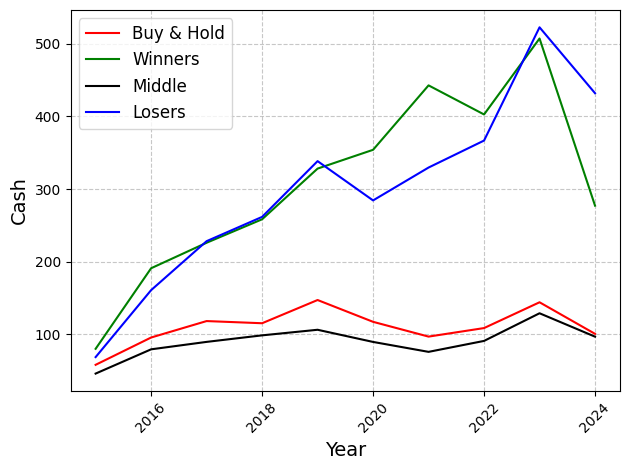

In [7]:
# Quarterly Growth Curve
import matplotlib.pyplot as plt

years = range(2015, 2025)
plt.plot(years, df7['Value'], label='Buy & Hold', color='RED')
plt.plot(years, df4['Winners'], label='Winners',color="GREEN")
plt.plot(years, df4['Median'], label='Middle', color="BLACK")
plt.plot(years, df4['Losers'], label='Losers', color="BLUE") 

#plt.title('Cash Values Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cash', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

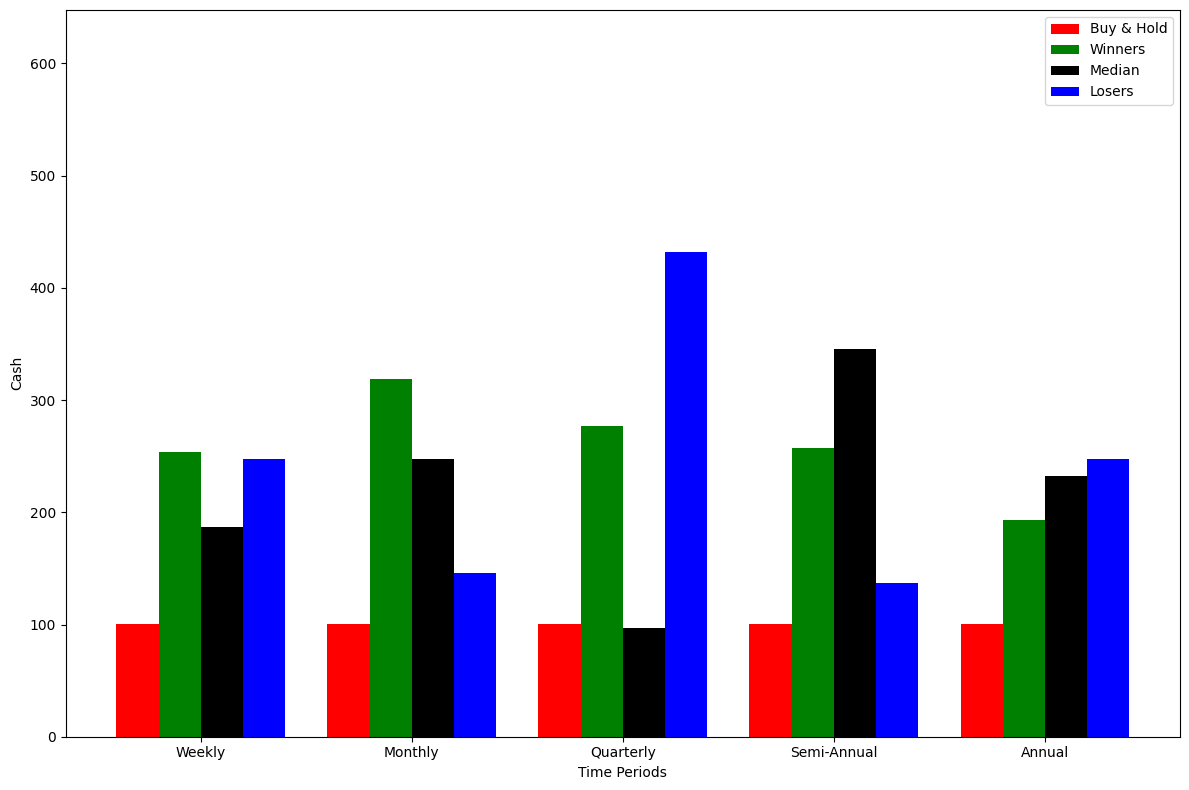

In [8]:
import matplotlib.pyplot as plt
import numpy as np


bh_values = [df7["Value"].iloc[-1],df7["Value"].iloc[-1],df7["Value"].iloc[-1],df7["Value"].iloc[-1],df7["Value"].iloc[-1]]
w_values = [df6["Winners"].iloc[-1],df5["Winners"].iloc[-1],df4["Winners"].iloc[-1],df3["Winners"].iloc[-1],df2["Winners"].iloc[-1]]
l_values = [df6["Losers"].iloc[-1],df5["Losers"].iloc[-1],df4["Losers"].iloc[-1],df3["Losers"].iloc[-1],df2["Losers"].iloc[-1]]
m_values = [df6["Median"].iloc[-1],df5["Median"].iloc[-1],df4["Median"].iloc[-1],df3["Median"].iloc[-1],df2["Median"].iloc[-1]]

categories = ["Weekly", 'Monthly','Quarterly', 'Semi-Annual', 'Annual']
labels = ['Buy & Hold', 'Winners', 'Median', 'Losers']

n_categories = len(categories)

x = np.arange(n_categories)

width = 0.2

plt.figure(figsize=(12, 8))

bars_bh = plt.bar(x - 1.5*width, bh_values, width, label='Buy & Hold', color='red')
bars_w = plt.bar(x - 0.5*width, w_values, width, label='Winners', color='green')
bars_m = plt.bar(x + 0.5*width, m_values, width, label='Median', color='black')
bars_l = plt.bar(x + 1.5*width, l_values, width, label='Losers', color='blue')


plt.xlabel('Time Periods')
plt.ylabel('Cash')
#plt.title('Cash Values by Category and Time Period')
plt.xticks(x, categories)
plt.legend()

def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

max_value = max(max(bh_values), max(w_values), max(l_values), max(m_values))
plt.ylim(0, max_value * 1.5) 

plt.tight_layout()
plt.show()


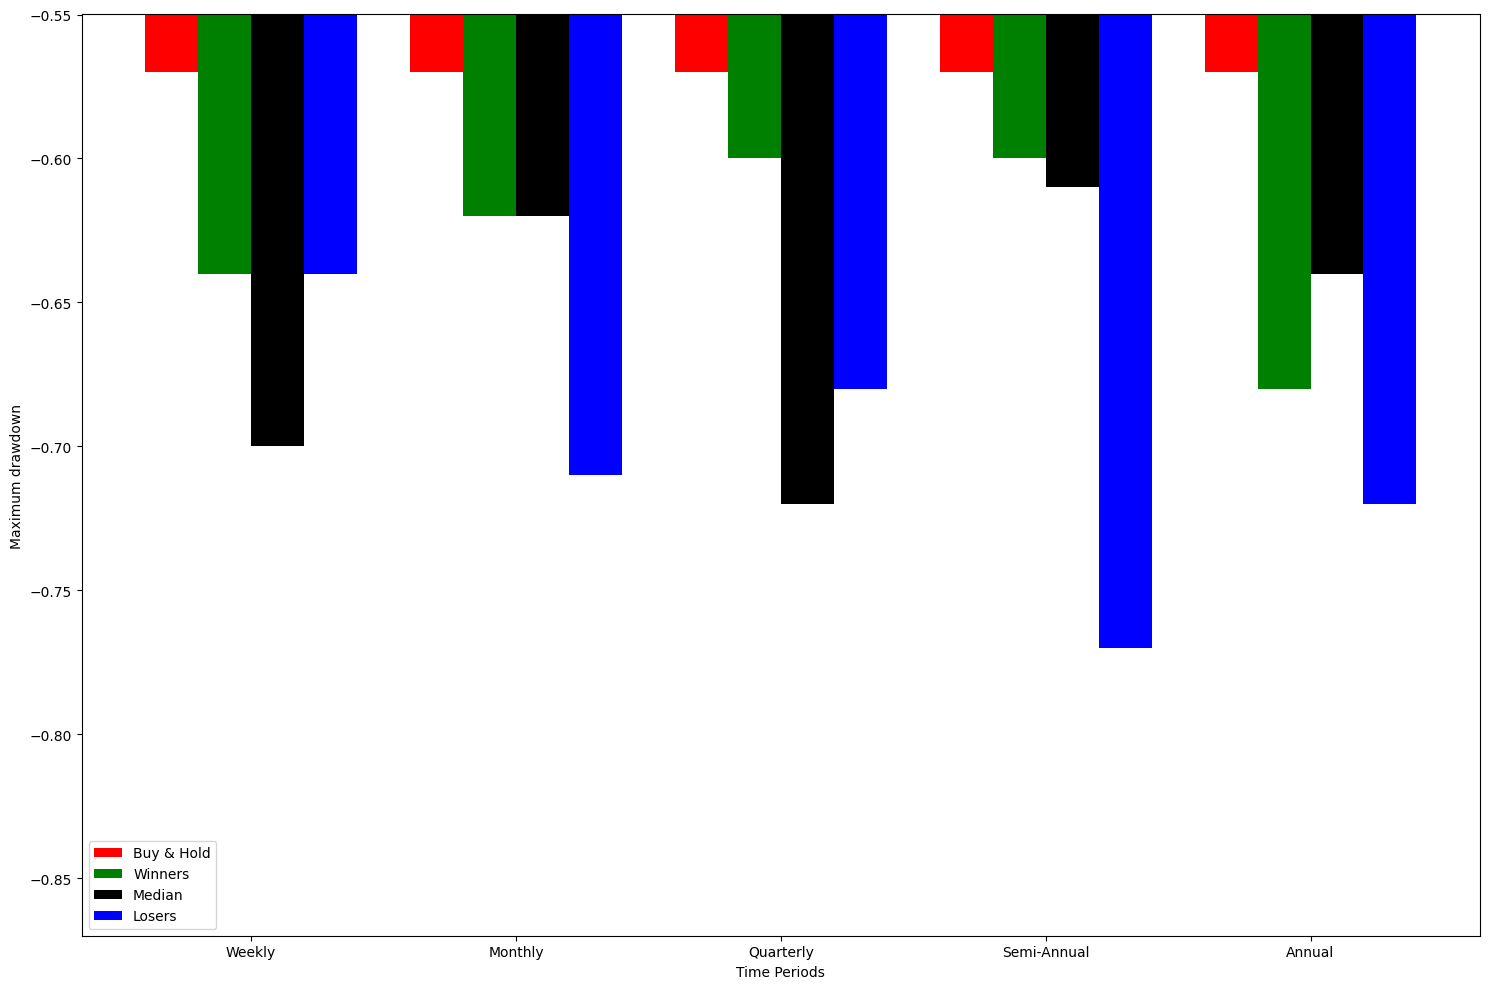

In [9]:
import matplotlib.pyplot as plt
import numpy as np

bh_values = [bh_week_maxdd,bh_mon_maxdd,bh_quar_maxdd,bh_sa_maxdd,bh_a_maxdd]
w_values = [w_week_maxdd,w_mon_maxdd,w_quar_maxdd,w_sa_maxdd,w_a_maxdd]
l_values = [l_week_maxdd,l_mon_maxdd,l_quar_maxdd,l_sa_maxdd,l_a_maxdd]
m_values = [m_week_maxdd,m_mon_maxdd,m_quar_maxdd,m_sa_maxdd,m_a_maxdd]

categories = ["Weekly",'Monthly','Quarterly', 'Semi-Annual', 'Annual']
labels = ['Buy & Hold', 'Winners', 'Median', 'Losers']


n_categories = len(categories)

x = np.arange(n_categories)

width = 0.2

plt.figure(figsize=(15, 10))

bars_bh = plt.bar(x - 1.5*width, bh_values, width, label='Buy & Hold', color='red')
bars_w = plt.bar(x - 0.5*width, w_values, width, label='Winners', color='green')
bars_m = plt.bar(x + 0.5*width, m_values, width, label='Median', color='black')
bars_l = plt.bar(x + 1.5*width, l_values, width, label='Losers', color='blue')



plt.xlabel('Time Periods')
plt.ylabel('Maximum drawdown')
#plt.title('Cash Values by Category and Time Period')
plt.xticks(x, categories)
plt.legend()


# Adjust y-scale to increase negative direction
y_min = min(min(bh_values), min(w_values), min(l_values), min(m_values))
y_max = max(max(bh_values), max(w_values), max(l_values), max(m_values))
y_range = y_max - y_min

# Extend the lower limit further into the negative
plt.ylim(y_min - 0.5 * y_range, y_max + 0.1 * y_range)



def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='top')

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empyrical import max_drawdown
from calendar import monthrange
import warnings


warnings.filterwarnings("ignore")
#Annual rebalancing
def yearly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025): 
        start_date = f"{year-1}-12-31"
        end_date = f"{year}-12-31"
        start_price = df['Adj Close'].loc[:start_date].iloc[-1]
        end_price = df['Adj Close'].loc[:end_date].iloc[-1]
        yearly_return = (end_price - start_price) / start_price
        returns[year] = yearly_return
    return pd.Series(returns)

tickers = ['SID', 'GGB', 'SBS', 'SUZ', 'VALE', 'PBR', 'ITUB', 'BAK', 'BBD']

data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}

yearly_returns_dict = {key: yearly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(yearly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_annual_w = []
cash_annual_m = []
cash_annual_l = []

for year in range(2014, 2024):
    sorted_returns = final_df.loc[year].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_year = year + 1
    if next_year in final_df.index:
        returns_next_year_w = final_df.loc[next_year][last_three.index]
        total_return_w = ((cash_w / 3) * (1 + returns_next_year_w)).sum()
        cash_w = total_return_w
        cash_annual_w.append((year + 1, cash_w))
        returns_next_year_m = final_df.loc[next_year][middle_three.index]
        total_return_m = ((cash_m / 3) * (1 + returns_next_year_m)).sum()
        cash_m = total_return_m
        cash_annual_m.append((year + 1, cash_m))
        returns_next_year_l = final_df.loc[next_year][first_three.index]
        total_return_l = ((cash_l / 3) * (1 + returns_next_year_l)).sum()
        cash_l = total_return_l
        cash_annual_l.append((year + 1, cash_l))

years_w, cash_values_w = zip(*cash_annual_w)
years_m, cash_values_m = zip(*cash_annual_m)
years_l, cash_values_l = zip(*cash_annual_l)

years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w})
df1["Median"]=cash_values_m
df1["Losers"]=cash_values_l

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in range(2014, 2025):
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for year in range(2014, 2025):
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[year].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_year = selected_returns[selected_returns.index.year == year+1]
        avg_daily_returns = selected_returns_year.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_a = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_a_maxdd=max_drawdowns_values_a["top"]
m_a_maxdd=max_drawdowns_values_a["middle"]
l_a_maxdd=max_drawdowns_values_a["bottom"]

df2=pd.DataFrame()
df2=df1
df2.head(10)
#df1.to_csv("annual.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2015,71.730792,75.687146,48.152123,-28.269208,-24.312854,-51.847877,31.553550,44.009466,57.672008,-0.895912,-0.552446,-0.899013,-39.205379,-39.457041,-63.088658
2016,109.274242,188.969377,113.210745,52.339376,149.671692,135.110602,31.228605,63.316929,60.878696,1.676007,2.363850,2.219341,-14.201723,-33.310362,-27.816144
2017,108.052920,269.037727,150.424717,-1.117666,42.371071,32.871412,42.628474,30.143031,24.936112,-0.026219,1.405667,1.318225,-42.261988,-21.483017,-14.601500
2018,135.899739,259.592912,160.795641,25.771463,-3.510591,6.894428,31.873226,32.361349,44.304099,0.808561,-0.108481,0.155616,-16.417335,-36.591091,-35.087581
2019,150.623440,303.625454,226.180155,10.834238,16.962151,40.663114,27.011783,30.318552,33.348976,0.401093,0.559464,1.219321,-29.484898,-27.285684,-27.666710
2020,164.858700,203.453679,231.384259,9.450893,-32.991890,2.300867,72.192956,69.087214,61.794418,0.130912,-0.477540,0.037234,-66.366900,-63.924368,-61.296017
2021,149.996001,214.541151,324.961112,-9.015417,5.449629,40.442186,37.362476,37.742030,36.176466,-0.241296,0.144392,1.117914,-46.299172,-25.761555,-26.967713
2022,164.630142,262.411253,311.287547,9.756354,22.312783,-4.207754,41.503457,35.184324,42.510811,0.235073,0.634168,-0.098981,-31.803408,-32.927395,-41.503903
2023,269.288089,284.690009,415.556264,63.571559,8.490015,33.495949,28.100049,26.236074,36.826911,2.262329,0.323601,0.909551,-15.964537,-22.437612,-29.988911
